In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json

import xgboost as xgb
print("xgb.__version__:", xgb.__version__)

from sklearn.model_selection import StratifiedGroupKFold

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

xgb.__version__: 2.1.1


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# Load the feature selection results
with open('../feat_selection/select_optuna_lgbm.json', 'r') as f:
    feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', [])
categorical_cols = feature_selection.get('categorical', [])

print("Numerical features:", len(numerical_cols))
print("Categorical features:", len(categorical_cols))

Numerical features: 296
Categorical features: 5


In [4]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 368
Categorical Columns: 5


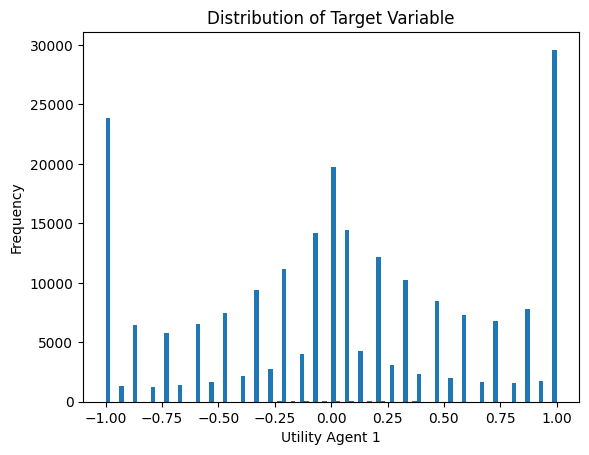

In [5]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

***
### train model


In [6]:
def train_models(
        df_train,
        target,
        numerical_cols,
        categorical_cols,
        num_folds=5,
        cv_random_state=2112,
    ):
    # Define the number of folds for cross-validation
    group_col = "GameRulesetName"
    y_col = "utility_agent1_rank"
    gkf = StratifiedGroupKFold(n_splits=num_folds, random_state=cv_random_state, shuffle=True)
    split_list = gkf.split(df_train, groups=df_train[group_col], y=df_train[y_col])

    # Define the parameters
    params = {
        'objective': "reg:squarederror",
        'eval_metric': 'rmse',
        'max_depth': 7,
        'learning_rate': 0.1,
        'alpha': 0.1,  # Equivalent to reg_alpha in LightGBM
        'lambda': 0.1,  # Equivalent to reg_lambda in LightGBM
        'colsample_bytree': 0.8,  # Equivalent to feature_fraction in LightGBM
        'seed': 2112,
        'verbosity': 0,  # Equivalent to verbose: -1 in LightGBM
    }

    trained_models = []
    oof = pd.DataFrame(index=df_train.index, columns=[f'{target}_true', f'{target}_pred'])
    oof_scores = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]

        feature_types = [
            "c" if col in categorical_cols else "q" 
            for col in numerical_cols + categorical_cols
        ]
        
        # Convert to DMatrix format
        train_data = xgb.DMatrix(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            feature_types=feature_types,
            enable_categorical=True,
        )
        val_data = xgb.DMatrix(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            feature_types=feature_types,
            enable_categorical=True,
        )

        # Train the model
        model = xgb.train(
            params,
            train_data,
            num_boost_round=2000,
            evals=[(val_data, 'val')],
            verbose_eval=25,
        )
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(val_data)
        y_pred = np.clip(y_pred, -1, 1)
        
        # Compute RMSE on scaled values
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores

In [7]:
# call the function
trained_models1, oof1, oof_scores1 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    num_folds=5,
    cv_random_state=2112,
)
# save oof predictions
oof1.to_csv(path_results / 'oof_xgboost_cv1.csv', index=False)

/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:909: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 1


[0]	val-rmse:0.60416


[25]	val-rmse:0.49575


[50]	val-rmse:0.47854


[75]	val-rmse:0.47466


[100]	val-rmse:0.46960


[125]	val-rmse:0.46659


[150]	val-rmse:0.46373


[175]	val-rmse:0.46127


[200]	val-rmse:0.46086


[225]	val-rmse:0.45971


[250]	val-rmse:0.45842


[275]	val-rmse:0.45686


[300]	val-rmse:0.45600


[325]	val-rmse:0.45567


[350]	val-rmse:0.45516


[375]	val-rmse:0.45413


[400]	val-rmse:0.45383


[425]	val-rmse:0.45326


[450]	val-rmse:0.45273


[475]	val-rmse:0.45267


[500]	val-rmse:0.45264


[525]	val-rmse:0.45245


[550]	val-rmse:0.45206


[575]	val-rmse:0.45197


[600]	val-rmse:0.45207


[625]	val-rmse:0.45199


[650]	val-rmse:0.45194


[675]	val-rmse:0.45184


[700]	val-rmse:0.45174


[725]	val-rmse:0.45184


[750]	val-rmse:0.45190


[775]	val-rmse:0.45189


[800]	val-rmse:0.45191


[825]	val-rmse:0.45193


[850]	val-rmse:0.45196


[875]	val-rmse:0.45197


[900]	val-rmse:0.45201


[925]	val-rmse:0.45206


[950]	val-rmse:0.45224


[975]	val-rmse:0.45226


[1000]	val-rmse:0.45224


[1025]	val-rmse:0.45227


[1050]	val-rmse:0.45238


[1075]	val-rmse:0.45233


[1100]	val-rmse:0.45234


[1125]	val-rmse:0.45236


[1150]	val-rmse:0.45250


[1175]	val-rmse:0.45246


[1200]	val-rmse:0.45240


[1225]	val-rmse:0.45237


[1250]	val-rmse:0.45239


[1275]	val-rmse:0.45243


[1300]	val-rmse:0.45247


[1325]	val-rmse:0.45259


[1350]	val-rmse:0.45269


[1375]	val-rmse:0.45270


[1400]	val-rmse:0.45269


[1425]	val-rmse:0.45273


[1450]	val-rmse:0.45278


[1475]	val-rmse:0.45274


[1500]	val-rmse:0.45276


[1525]	val-rmse:0.45277


[1550]	val-rmse:0.45283


[1575]	val-rmse:0.45282


[1600]	val-rmse:0.45292


[1625]	val-rmse:0.45300


[1650]	val-rmse:0.45303


[1675]	val-rmse:0.45301


[1700]	val-rmse:0.45304


[1725]	val-rmse:0.45308


[1750]	val-rmse:0.45310


[1775]	val-rmse:0.45309


[1800]	val-rmse:0.45312


[1825]	val-rmse:0.45309


[1850]	val-rmse:0.45313


[1875]	val-rmse:0.45320


[1900]	val-rmse:0.45317


[1925]	val-rmse:0.45323


[1950]	val-rmse:0.45326


[1975]	val-rmse:0.45334


[1999]	val-rmse:0.45338


Fold 1 - RMSE: 0.4523966115074206
Fold 2


[0]	val-rmse:0.61634


[25]	val-rmse:0.50014


[50]	val-rmse:0.48507


[75]	val-rmse:0.47750


[100]	val-rmse:0.46997


[125]	val-rmse:0.46625


[150]	val-rmse:0.46389


[175]	val-rmse:0.46217


[200]	val-rmse:0.46018


[225]	val-rmse:0.45903


[250]	val-rmse:0.45812


[275]	val-rmse:0.45691


[300]	val-rmse:0.45648


[325]	val-rmse:0.45580


[350]	val-rmse:0.45546


[375]	val-rmse:0.45498


[400]	val-rmse:0.45471


[425]	val-rmse:0.45461


[450]	val-rmse:0.45450


[475]	val-rmse:0.45431


[500]	val-rmse:0.45404


[525]	val-rmse:0.45372


[550]	val-rmse:0.45381


[575]	val-rmse:0.45381


[600]	val-rmse:0.45368


[625]	val-rmse:0.45377


[650]	val-rmse:0.45367


[675]	val-rmse:0.45374


[700]	val-rmse:0.45366


[725]	val-rmse:0.45352


[750]	val-rmse:0.45355


[775]	val-rmse:0.45359


[800]	val-rmse:0.45356


[825]	val-rmse:0.45367


[850]	val-rmse:0.45372


[875]	val-rmse:0.45380


[900]	val-rmse:0.45354


[925]	val-rmse:0.45360


[950]	val-rmse:0.45366


[975]	val-rmse:0.45364


[1000]	val-rmse:0.45372


[1025]	val-rmse:0.45380


[1050]	val-rmse:0.45394


[1075]	val-rmse:0.45388


[1100]	val-rmse:0.45404


[1125]	val-rmse:0.45408


[1150]	val-rmse:0.45410


[1175]	val-rmse:0.45408


[1200]	val-rmse:0.45401


[1225]	val-rmse:0.45400


[1250]	val-rmse:0.45393


[1275]	val-rmse:0.45391


[1300]	val-rmse:0.45387


[1325]	val-rmse:0.45382


[1350]	val-rmse:0.45388


[1375]	val-rmse:0.45383


[1400]	val-rmse:0.45383


[1425]	val-rmse:0.45390


[1450]	val-rmse:0.45396


[1475]	val-rmse:0.45394


[1500]	val-rmse:0.45398


[1525]	val-rmse:0.45403


[1550]	val-rmse:0.45412


[1575]	val-rmse:0.45421


[1600]	val-rmse:0.45423


[1625]	val-rmse:0.45423


[1650]	val-rmse:0.45423


[1675]	val-rmse:0.45423


[1700]	val-rmse:0.45425


[1725]	val-rmse:0.45432


[1750]	val-rmse:0.45432


[1775]	val-rmse:0.45442


[1800]	val-rmse:0.45440


[1825]	val-rmse:0.45441


[1850]	val-rmse:0.45441


[1875]	val-rmse:0.45440


[1900]	val-rmse:0.45445


[1925]	val-rmse:0.45451


[1950]	val-rmse:0.45454


[1975]	val-rmse:0.45457


[1999]	val-rmse:0.45461


Fold 2 - RMSE: 0.4536003793249102
Fold 3


[0]	val-rmse:0.58265


[25]	val-rmse:0.46360


[50]	val-rmse:0.44614


[75]	val-rmse:0.44286


[100]	val-rmse:0.43910


[125]	val-rmse:0.43783


[150]	val-rmse:0.43540


[175]	val-rmse:0.43390


[200]	val-rmse:0.43234


[225]	val-rmse:0.43074


[250]	val-rmse:0.42908


[275]	val-rmse:0.42849


[300]	val-rmse:0.42776


[325]	val-rmse:0.42706


[350]	val-rmse:0.42670


[375]	val-rmse:0.42650


[400]	val-rmse:0.42639


[425]	val-rmse:0.42621


[450]	val-rmse:0.42579


[475]	val-rmse:0.42536


[500]	val-rmse:0.42524


[525]	val-rmse:0.42529


[550]	val-rmse:0.42527


[575]	val-rmse:0.42504


[600]	val-rmse:0.42505


[625]	val-rmse:0.42501


[650]	val-rmse:0.42497


[675]	val-rmse:0.42496


[700]	val-rmse:0.42512


[725]	val-rmse:0.42503


[750]	val-rmse:0.42494


[775]	val-rmse:0.42486


[800]	val-rmse:0.42489


[825]	val-rmse:0.42488


[850]	val-rmse:0.42487


[875]	val-rmse:0.42497


[900]	val-rmse:0.42498


[925]	val-rmse:0.42498


[950]	val-rmse:0.42501


[975]	val-rmse:0.42509


[1000]	val-rmse:0.42511


[1025]	val-rmse:0.42517


[1050]	val-rmse:0.42512


[1075]	val-rmse:0.42520


[1100]	val-rmse:0.42533


[1125]	val-rmse:0.42539


[1150]	val-rmse:0.42541


[1175]	val-rmse:0.42544


[1200]	val-rmse:0.42546


[1225]	val-rmse:0.42547


[1250]	val-rmse:0.42552


[1275]	val-rmse:0.42555


[1300]	val-rmse:0.42560


[1325]	val-rmse:0.42561


[1350]	val-rmse:0.42565


[1375]	val-rmse:0.42569


[1400]	val-rmse:0.42569


[1425]	val-rmse:0.42574


[1450]	val-rmse:0.42581


[1475]	val-rmse:0.42591


[1500]	val-rmse:0.42581


[1525]	val-rmse:0.42587


[1550]	val-rmse:0.42597


[1575]	val-rmse:0.42600


[1600]	val-rmse:0.42599


[1625]	val-rmse:0.42598


[1650]	val-rmse:0.42603


[1675]	val-rmse:0.42609


[1700]	val-rmse:0.42617


[1725]	val-rmse:0.42618


[1750]	val-rmse:0.42625


[1775]	val-rmse:0.42630


[1800]	val-rmse:0.42636


[1825]	val-rmse:0.42642


[1850]	val-rmse:0.42642


[1875]	val-rmse:0.42646


[1900]	val-rmse:0.42651


[1925]	val-rmse:0.42650


[1950]	val-rmse:0.42654


[1975]	val-rmse:0.42656


[1999]	val-rmse:0.42661


Fold 3 - RMSE: 0.42574448570149087
Fold 4


[0]	val-rmse:0.61525


[25]	val-rmse:0.49496


[50]	val-rmse:0.47903


[75]	val-rmse:0.47245


[100]	val-rmse:0.46843


[125]	val-rmse:0.46366


[150]	val-rmse:0.46002


[175]	val-rmse:0.45772


[200]	val-rmse:0.45663


[225]	val-rmse:0.45568


[250]	val-rmse:0.45476


[275]	val-rmse:0.45409


[300]	val-rmse:0.45332


[325]	val-rmse:0.45290


[350]	val-rmse:0.45257


[375]	val-rmse:0.45204


[400]	val-rmse:0.45146


[425]	val-rmse:0.45138


[450]	val-rmse:0.45131


[475]	val-rmse:0.45128


[500]	val-rmse:0.45121


[525]	val-rmse:0.45094


[550]	val-rmse:0.45060


[575]	val-rmse:0.45039


[600]	val-rmse:0.45009


[625]	val-rmse:0.44995


[650]	val-rmse:0.44981


[675]	val-rmse:0.44965


[700]	val-rmse:0.44952


[725]	val-rmse:0.44935


[750]	val-rmse:0.44913


[775]	val-rmse:0.44905


[800]	val-rmse:0.44899


[825]	val-rmse:0.44901


[850]	val-rmse:0.44889


[875]	val-rmse:0.44890


[900]	val-rmse:0.44891


[925]	val-rmse:0.44885


[950]	val-rmse:0.44886


[975]	val-rmse:0.44883


[1000]	val-rmse:0.44898


[1025]	val-rmse:0.44892


[1050]	val-rmse:0.44891


[1075]	val-rmse:0.44892


[1100]	val-rmse:0.44890


[1125]	val-rmse:0.44887


[1150]	val-rmse:0.44884


[1175]	val-rmse:0.44890


[1200]	val-rmse:0.44894


[1225]	val-rmse:0.44892


[1250]	val-rmse:0.44896


[1275]	val-rmse:0.44887


[1300]	val-rmse:0.44881


[1325]	val-rmse:0.44885


[1350]	val-rmse:0.44886


[1375]	val-rmse:0.44884


[1400]	val-rmse:0.44894


[1425]	val-rmse:0.44900


[1450]	val-rmse:0.44901


[1475]	val-rmse:0.44909


[1500]	val-rmse:0.44911


[1525]	val-rmse:0.44908


[1550]	val-rmse:0.44913


[1575]	val-rmse:0.44908


[1600]	val-rmse:0.44909


[1625]	val-rmse:0.44916


[1650]	val-rmse:0.44921


[1675]	val-rmse:0.44918


[1700]	val-rmse:0.44917


[1725]	val-rmse:0.44921


[1750]	val-rmse:0.44922


[1775]	val-rmse:0.44924


[1800]	val-rmse:0.44919


[1825]	val-rmse:0.44914


[1850]	val-rmse:0.44917


[1875]	val-rmse:0.44918


[1900]	val-rmse:0.44919


[1925]	val-rmse:0.44915


[1950]	val-rmse:0.44911


[1975]	val-rmse:0.44912


[1999]	val-rmse:0.44913


Fold 4 - RMSE: 0.4481475364026459
Fold 5


[0]	val-rmse:0.61208


[25]	val-rmse:0.49965


[50]	val-rmse:0.48626


[75]	val-rmse:0.48219


[100]	val-rmse:0.47798


[125]	val-rmse:0.47592


[150]	val-rmse:0.47376


[175]	val-rmse:0.47257


[200]	val-rmse:0.47138


[225]	val-rmse:0.47091


[250]	val-rmse:0.47019


[275]	val-rmse:0.46978


[300]	val-rmse:0.46974


[325]	val-rmse:0.46894


[350]	val-rmse:0.46857


[375]	val-rmse:0.46816


[400]	val-rmse:0.46807


[425]	val-rmse:0.46766


[450]	val-rmse:0.46759


[475]	val-rmse:0.46700


[500]	val-rmse:0.46695


[525]	val-rmse:0.46708


[550]	val-rmse:0.46699


[575]	val-rmse:0.46675


[600]	val-rmse:0.46678


[625]	val-rmse:0.46685


[650]	val-rmse:0.46691


[675]	val-rmse:0.46691


[700]	val-rmse:0.46690


[725]	val-rmse:0.46677


[750]	val-rmse:0.46670


[775]	val-rmse:0.46665


[800]	val-rmse:0.46665


[825]	val-rmse:0.46657


[850]	val-rmse:0.46662


[875]	val-rmse:0.46657


[900]	val-rmse:0.46653


[925]	val-rmse:0.46652


[950]	val-rmse:0.46662


[975]	val-rmse:0.46654


[1000]	val-rmse:0.46665


[1025]	val-rmse:0.46670


[1050]	val-rmse:0.46670


[1075]	val-rmse:0.46676


[1100]	val-rmse:0.46678


[1125]	val-rmse:0.46679


[1150]	val-rmse:0.46673


[1175]	val-rmse:0.46679


[1200]	val-rmse:0.46672


[1225]	val-rmse:0.46680


[1250]	val-rmse:0.46691


[1275]	val-rmse:0.46694


[1300]	val-rmse:0.46696


[1325]	val-rmse:0.46694


[1350]	val-rmse:0.46686


[1375]	val-rmse:0.46690


[1400]	val-rmse:0.46693


[1425]	val-rmse:0.46697


[1450]	val-rmse:0.46699


[1475]	val-rmse:0.46704


[1500]	val-rmse:0.46701


[1525]	val-rmse:0.46708


[1550]	val-rmse:0.46713


[1575]	val-rmse:0.46712


[1600]	val-rmse:0.46715


[1625]	val-rmse:0.46716


[1650]	val-rmse:0.46720


[1675]	val-rmse:0.46722


[1700]	val-rmse:0.46721


[1725]	val-rmse:0.46723


[1750]	val-rmse:0.46733


[1775]	val-rmse:0.46730


[1800]	val-rmse:0.46732


[1825]	val-rmse:0.46732


[1850]	val-rmse:0.46739


[1875]	val-rmse:0.46740


[1900]	val-rmse:0.46748


[1925]	val-rmse:0.46748


[1950]	val-rmse:0.46750


[1975]	val-rmse:0.46754


[1999]	val-rmse:0.46754


Fold 5 - RMSE: 0.4667936217096156
List of oof scores: [0.4523966115074206, 0.4536003793249102, 0.42574448570149087, 0.4481475364026459, 0.4667936217096156]
Average oof score: 0.4493365269292166


In [8]:
# call the function
trained_models2, oof2, oof_scores2 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    num_folds=5,
    cv_random_state=19,
)
# save oof predictions
oof2.to_csv(path_results / 'oof_xgboost_cv2.csv', index=False)

/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:909: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 1


[0]	val-rmse:0.60082


[25]	val-rmse:0.48881


[50]	val-rmse:0.46642


[75]	val-rmse:0.46134


[100]	val-rmse:0.45375


[125]	val-rmse:0.45010


[150]	val-rmse:0.44701


[175]	val-rmse:0.44393


[200]	val-rmse:0.44262


[225]	val-rmse:0.44164


[250]	val-rmse:0.44073


[275]	val-rmse:0.43979


[300]	val-rmse:0.43875


[325]	val-rmse:0.43812


[350]	val-rmse:0.43711


[375]	val-rmse:0.43672


[400]	val-rmse:0.43632


[425]	val-rmse:0.43584


[450]	val-rmse:0.43560


[475]	val-rmse:0.43525


[500]	val-rmse:0.43501


[525]	val-rmse:0.43499


[550]	val-rmse:0.43479


[575]	val-rmse:0.43457


[600]	val-rmse:0.43445


[625]	val-rmse:0.43438


[650]	val-rmse:0.43417


[675]	val-rmse:0.43416


[700]	val-rmse:0.43413


[725]	val-rmse:0.43419


[750]	val-rmse:0.43402


[775]	val-rmse:0.43409


[800]	val-rmse:0.43399


[825]	val-rmse:0.43397


[850]	val-rmse:0.43404


[875]	val-rmse:0.43401


[900]	val-rmse:0.43396


[925]	val-rmse:0.43405


[950]	val-rmse:0.43416


[975]	val-rmse:0.43419


[1000]	val-rmse:0.43432


[1025]	val-rmse:0.43434


[1050]	val-rmse:0.43436


[1075]	val-rmse:0.43436


[1100]	val-rmse:0.43435


[1125]	val-rmse:0.43437


[1150]	val-rmse:0.43440


[1175]	val-rmse:0.43436


[1200]	val-rmse:0.43448


[1225]	val-rmse:0.43446


[1250]	val-rmse:0.43442


[1275]	val-rmse:0.43440


[1300]	val-rmse:0.43444


[1325]	val-rmse:0.43438


[1350]	val-rmse:0.43436


[1375]	val-rmse:0.43437


[1400]	val-rmse:0.43444


[1425]	val-rmse:0.43442


[1450]	val-rmse:0.43441


[1475]	val-rmse:0.43436


[1500]	val-rmse:0.43433


[1525]	val-rmse:0.43435


[1550]	val-rmse:0.43437


[1575]	val-rmse:0.43439


[1600]	val-rmse:0.43444


[1625]	val-rmse:0.43447


[1650]	val-rmse:0.43446


[1675]	val-rmse:0.43446


[1700]	val-rmse:0.43448


[1725]	val-rmse:0.43452


[1750]	val-rmse:0.43453


[1775]	val-rmse:0.43460


[1800]	val-rmse:0.43464


[1825]	val-rmse:0.43465


[1850]	val-rmse:0.43466


[1875]	val-rmse:0.43473


[1900]	val-rmse:0.43478


[1925]	val-rmse:0.43488


[1950]	val-rmse:0.43489


[1975]	val-rmse:0.43492


[1999]	val-rmse:0.43494


Fold 1 - RMSE: 0.433845340795788
Fold 2


[0]	val-rmse:0.61589


[25]	val-rmse:0.49692


[50]	val-rmse:0.47910


[75]	val-rmse:0.47188


[100]	val-rmse:0.46892


[125]	val-rmse:0.46577


[150]	val-rmse:0.46381


[175]	val-rmse:0.46060


[200]	val-rmse:0.45892


[225]	val-rmse:0.45838


[250]	val-rmse:0.45822


[275]	val-rmse:0.45764


[300]	val-rmse:0.45694


[325]	val-rmse:0.45660


[350]	val-rmse:0.45697


[375]	val-rmse:0.45691


[400]	val-rmse:0.45661


[425]	val-rmse:0.45656


[450]	val-rmse:0.45649


[475]	val-rmse:0.45654


[500]	val-rmse:0.45674


[525]	val-rmse:0.45663


[550]	val-rmse:0.45660


[575]	val-rmse:0.45665


[600]	val-rmse:0.45666


[625]	val-rmse:0.45671


[650]	val-rmse:0.45682


[675]	val-rmse:0.45683


[700]	val-rmse:0.45702


[725]	val-rmse:0.45695


[750]	val-rmse:0.45700


[775]	val-rmse:0.45700


[800]	val-rmse:0.45712


[825]	val-rmse:0.45726


[850]	val-rmse:0.45732


[875]	val-rmse:0.45741


[900]	val-rmse:0.45742


[925]	val-rmse:0.45744


[950]	val-rmse:0.45753


[975]	val-rmse:0.45761


[1000]	val-rmse:0.45767


[1025]	val-rmse:0.45777


[1050]	val-rmse:0.45777


[1075]	val-rmse:0.45787


[1100]	val-rmse:0.45785


[1125]	val-rmse:0.45786


[1150]	val-rmse:0.45789


[1175]	val-rmse:0.45786


[1200]	val-rmse:0.45791


[1225]	val-rmse:0.45800


[1250]	val-rmse:0.45809


[1275]	val-rmse:0.45810


[1300]	val-rmse:0.45816


[1325]	val-rmse:0.45818


[1350]	val-rmse:0.45814


[1375]	val-rmse:0.45819


[1400]	val-rmse:0.45822


[1425]	val-rmse:0.45831


[1450]	val-rmse:0.45837


[1475]	val-rmse:0.45847


[1500]	val-rmse:0.45848


[1525]	val-rmse:0.45855


[1550]	val-rmse:0.45857


[1575]	val-rmse:0.45863


[1600]	val-rmse:0.45865


[1625]	val-rmse:0.45869


[1650]	val-rmse:0.45873


[1675]	val-rmse:0.45877


[1700]	val-rmse:0.45878


[1725]	val-rmse:0.45883


[1750]	val-rmse:0.45884


[1775]	val-rmse:0.45884


[1800]	val-rmse:0.45889


[1825]	val-rmse:0.45894


[1850]	val-rmse:0.45899


[1875]	val-rmse:0.45904


[1900]	val-rmse:0.45904


[1925]	val-rmse:0.45912


[1950]	val-rmse:0.45914


[1975]	val-rmse:0.45917


[1999]	val-rmse:0.45927


Fold 2 - RMSE: 0.4580243498089761
Fold 3


[0]	val-rmse:0.58370


[25]	val-rmse:0.48467


[50]	val-rmse:0.47390


[75]	val-rmse:0.46797


[100]	val-rmse:0.46728


[125]	val-rmse:0.46525


[150]	val-rmse:0.46353


[175]	val-rmse:0.46139


[200]	val-rmse:0.46063


[225]	val-rmse:0.45957


[250]	val-rmse:0.45850


[275]	val-rmse:0.45790


[300]	val-rmse:0.45748


[325]	val-rmse:0.45724


[350]	val-rmse:0.45729


[375]	val-rmse:0.45692


[400]	val-rmse:0.45676


[425]	val-rmse:0.45651


[450]	val-rmse:0.45603


[475]	val-rmse:0.45582


[500]	val-rmse:0.45569


[525]	val-rmse:0.45568


[550]	val-rmse:0.45581


[575]	val-rmse:0.45575


[600]	val-rmse:0.45574


[625]	val-rmse:0.45564


[650]	val-rmse:0.45557


[675]	val-rmse:0.45568


[700]	val-rmse:0.45564


[725]	val-rmse:0.45556


[750]	val-rmse:0.45539


[775]	val-rmse:0.45542


[800]	val-rmse:0.45529


[825]	val-rmse:0.45527


[850]	val-rmse:0.45522


[875]	val-rmse:0.45522


[900]	val-rmse:0.45524


[925]	val-rmse:0.45531


[950]	val-rmse:0.45524


[975]	val-rmse:0.45539


[1000]	val-rmse:0.45546


[1025]	val-rmse:0.45547


[1050]	val-rmse:0.45554


[1075]	val-rmse:0.45553


[1100]	val-rmse:0.45563


[1125]	val-rmse:0.45566


[1150]	val-rmse:0.45570


[1175]	val-rmse:0.45575


[1200]	val-rmse:0.45574


[1225]	val-rmse:0.45588


[1250]	val-rmse:0.45600


[1275]	val-rmse:0.45606


[1300]	val-rmse:0.45611


[1325]	val-rmse:0.45615


[1350]	val-rmse:0.45615


[1375]	val-rmse:0.45624


[1400]	val-rmse:0.45629


[1425]	val-rmse:0.45632


[1450]	val-rmse:0.45630


[1475]	val-rmse:0.45632


[1500]	val-rmse:0.45642


[1525]	val-rmse:0.45647


[1550]	val-rmse:0.45651


[1575]	val-rmse:0.45658


[1600]	val-rmse:0.45654


[1625]	val-rmse:0.45657


[1650]	val-rmse:0.45649


[1675]	val-rmse:0.45656


[1700]	val-rmse:0.45660


[1725]	val-rmse:0.45668


[1750]	val-rmse:0.45670


[1775]	val-rmse:0.45679


[1800]	val-rmse:0.45679


[1825]	val-rmse:0.45681


[1850]	val-rmse:0.45680


[1875]	val-rmse:0.45680


[1900]	val-rmse:0.45680


[1925]	val-rmse:0.45682


[1950]	val-rmse:0.45680


[1975]	val-rmse:0.45684


[1999]	val-rmse:0.45686


Fold 3 - RMSE: 0.4557958382099543
Fold 4


[0]	val-rmse:0.60579


[25]	val-rmse:0.49254


[50]	val-rmse:0.47745


[75]	val-rmse:0.47249


[100]	val-rmse:0.46874


[125]	val-rmse:0.46620


[150]	val-rmse:0.46374


[175]	val-rmse:0.46120


[200]	val-rmse:0.45971


[225]	val-rmse:0.45890


[250]	val-rmse:0.45754


[275]	val-rmse:0.45657


[300]	val-rmse:0.45587


[325]	val-rmse:0.45584


[350]	val-rmse:0.45522


[375]	val-rmse:0.45493


[400]	val-rmse:0.45483


[425]	val-rmse:0.45471


[450]	val-rmse:0.45443


[475]	val-rmse:0.45446


[500]	val-rmse:0.45419


[525]	val-rmse:0.45399


[550]	val-rmse:0.45371


[575]	val-rmse:0.45366


[600]	val-rmse:0.45362


[625]	val-rmse:0.45363


[650]	val-rmse:0.45348


[675]	val-rmse:0.45342


[700]	val-rmse:0.45325


[725]	val-rmse:0.45335


[750]	val-rmse:0.45344


[775]	val-rmse:0.45339


[800]	val-rmse:0.45325


[825]	val-rmse:0.45327


[850]	val-rmse:0.45324


[875]	val-rmse:0.45318


[900]	val-rmse:0.45306


[925]	val-rmse:0.45303


[950]	val-rmse:0.45313


[975]	val-rmse:0.45309


[1000]	val-rmse:0.45301


[1025]	val-rmse:0.45280


[1050]	val-rmse:0.45296


[1075]	val-rmse:0.45292


[1100]	val-rmse:0.45300


[1125]	val-rmse:0.45309


[1150]	val-rmse:0.45312


[1175]	val-rmse:0.45317


[1200]	val-rmse:0.45325


[1225]	val-rmse:0.45331


[1250]	val-rmse:0.45320


[1275]	val-rmse:0.45322


[1300]	val-rmse:0.45330


[1325]	val-rmse:0.45332


[1350]	val-rmse:0.45336


[1375]	val-rmse:0.45336


[1400]	val-rmse:0.45332


[1425]	val-rmse:0.45335


[1450]	val-rmse:0.45336


[1475]	val-rmse:0.45335


[1500]	val-rmse:0.45339


[1525]	val-rmse:0.45337


[1550]	val-rmse:0.45339


[1575]	val-rmse:0.45336


[1600]	val-rmse:0.45340


[1625]	val-rmse:0.45346


[1650]	val-rmse:0.45346


[1675]	val-rmse:0.45349


[1700]	val-rmse:0.45352


[1725]	val-rmse:0.45355


[1750]	val-rmse:0.45359


[1775]	val-rmse:0.45365


[1800]	val-rmse:0.45372


[1825]	val-rmse:0.45375


[1850]	val-rmse:0.45380


[1875]	val-rmse:0.45382


[1900]	val-rmse:0.45383


[1925]	val-rmse:0.45385


[1950]	val-rmse:0.45383


[1975]	val-rmse:0.45382


[1999]	val-rmse:0.45383


Fold 4 - RMSE: 0.4527270568680092
Fold 5


[0]	val-rmse:0.61805


[25]	val-rmse:0.49766


[50]	val-rmse:0.48670


[75]	val-rmse:0.48224


[100]	val-rmse:0.47660


[125]	val-rmse:0.47390


[150]	val-rmse:0.47106


[175]	val-rmse:0.46943


[200]	val-rmse:0.46840


[225]	val-rmse:0.46651


[250]	val-rmse:0.46526


[275]	val-rmse:0.46432


[300]	val-rmse:0.46346


[325]	val-rmse:0.46315


[350]	val-rmse:0.46269


[375]	val-rmse:0.46252


[400]	val-rmse:0.46223


[425]	val-rmse:0.46200


[450]	val-rmse:0.46168


[475]	val-rmse:0.46116


[500]	val-rmse:0.46075


[525]	val-rmse:0.46076


[550]	val-rmse:0.46048


[575]	val-rmse:0.46039


[600]	val-rmse:0.46031


[625]	val-rmse:0.46018


[650]	val-rmse:0.45990


[675]	val-rmse:0.45986


[700]	val-rmse:0.45968


[725]	val-rmse:0.45959


[750]	val-rmse:0.45957


[775]	val-rmse:0.45949


[800]	val-rmse:0.45938


[825]	val-rmse:0.45945


[850]	val-rmse:0.45943


[875]	val-rmse:0.45946


[900]	val-rmse:0.45944


[925]	val-rmse:0.45937


[950]	val-rmse:0.45946


[975]	val-rmse:0.45942


[1000]	val-rmse:0.45939


[1025]	val-rmse:0.45935


[1050]	val-rmse:0.45942


[1075]	val-rmse:0.45943


[1100]	val-rmse:0.45945


[1125]	val-rmse:0.45951


[1150]	val-rmse:0.45956


[1175]	val-rmse:0.45962


[1200]	val-rmse:0.45970


[1225]	val-rmse:0.45972


[1250]	val-rmse:0.45973


[1275]	val-rmse:0.45979


[1300]	val-rmse:0.45985


[1325]	val-rmse:0.45988


[1350]	val-rmse:0.45986


[1375]	val-rmse:0.45989


[1400]	val-rmse:0.45996


[1425]	val-rmse:0.45997


[1450]	val-rmse:0.46005


[1475]	val-rmse:0.46010


[1500]	val-rmse:0.46009


[1525]	val-rmse:0.46010


[1550]	val-rmse:0.46017


[1575]	val-rmse:0.46017


[1600]	val-rmse:0.46018


[1625]	val-rmse:0.46021


[1650]	val-rmse:0.46027


[1675]	val-rmse:0.46027


[1700]	val-rmse:0.46029


[1725]	val-rmse:0.46037


[1750]	val-rmse:0.46040


[1775]	val-rmse:0.46046


[1800]	val-rmse:0.46048


[1825]	val-rmse:0.46051


[1850]	val-rmse:0.46051


[1875]	val-rmse:0.46050


[1900]	val-rmse:0.46050


[1925]	val-rmse:0.46053


[1950]	val-rmse:0.46052


[1975]	val-rmse:0.46055


[1999]	val-rmse:0.46055


Fold 5 - RMSE: 0.45982628242097723
List of oof scores: [0.433845340795788, 0.4580243498089761, 0.4557958382099543, 0.4527270568680092, 0.45982628242097723]
Average oof score: 0.452043773620741


In [9]:
# call the function
trained_models3, oof3, oof_scores3 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    num_folds=5,
    cv_random_state=23,
)
# save oof predictions
oof3.to_csv(path_results / 'oof_xgboost_cv3.csv', index=False)

/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:909: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 1


[0]	val-rmse:0.60085


[25]	val-rmse:0.49798


[50]	val-rmse:0.48212


[75]	val-rmse:0.47711


[100]	val-rmse:0.47057


[125]	val-rmse:0.46726


[150]	val-rmse:0.46375


[175]	val-rmse:0.46167


[200]	val-rmse:0.45956


[225]	val-rmse:0.45842


[250]	val-rmse:0.45760


[275]	val-rmse:0.45673


[300]	val-rmse:0.45628


[325]	val-rmse:0.45585


[350]	val-rmse:0.45552


[375]	val-rmse:0.45507


[400]	val-rmse:0.45483


[425]	val-rmse:0.45421


[450]	val-rmse:0.45406


[475]	val-rmse:0.45416


[500]	val-rmse:0.45410


[525]	val-rmse:0.45407


[550]	val-rmse:0.45387


[575]	val-rmse:0.45390


[600]	val-rmse:0.45398


[625]	val-rmse:0.45404


[650]	val-rmse:0.45397


[675]	val-rmse:0.45414


[700]	val-rmse:0.45413


[725]	val-rmse:0.45405


[750]	val-rmse:0.45394


[775]	val-rmse:0.45365


[800]	val-rmse:0.45375


[825]	val-rmse:0.45369


[850]	val-rmse:0.45375


[875]	val-rmse:0.45360


[900]	val-rmse:0.45366


[925]	val-rmse:0.45360


[950]	val-rmse:0.45356


[975]	val-rmse:0.45363


[1000]	val-rmse:0.45364


[1025]	val-rmse:0.45367


[1050]	val-rmse:0.45388


[1075]	val-rmse:0.45384


[1100]	val-rmse:0.45392


[1125]	val-rmse:0.45400


[1150]	val-rmse:0.45399


[1175]	val-rmse:0.45410


[1200]	val-rmse:0.45417


[1225]	val-rmse:0.45424


[1250]	val-rmse:0.45427


[1275]	val-rmse:0.45430


[1300]	val-rmse:0.45436


[1325]	val-rmse:0.45436


[1350]	val-rmse:0.45443


[1375]	val-rmse:0.45438


[1400]	val-rmse:0.45432


[1425]	val-rmse:0.45424


[1450]	val-rmse:0.45430


[1475]	val-rmse:0.45429


[1500]	val-rmse:0.45432


[1525]	val-rmse:0.45441


[1550]	val-rmse:0.45445


[1575]	val-rmse:0.45445


[1600]	val-rmse:0.45450


[1625]	val-rmse:0.45458


[1650]	val-rmse:0.45458


[1675]	val-rmse:0.45458


[1700]	val-rmse:0.45456


[1725]	val-rmse:0.45458


[1750]	val-rmse:0.45464


[1775]	val-rmse:0.45465


[1800]	val-rmse:0.45471


[1825]	val-rmse:0.45471


[1850]	val-rmse:0.45479


[1875]	val-rmse:0.45481


[1900]	val-rmse:0.45476


[1925]	val-rmse:0.45481


[1950]	val-rmse:0.45477


[1975]	val-rmse:0.45477


[1999]	val-rmse:0.45481


Fold 1 - RMSE: 0.4540786175905146
Fold 2


[0]	val-rmse:0.60600


[25]	val-rmse:0.49956


[50]	val-rmse:0.48154


[75]	val-rmse:0.47769


[100]	val-rmse:0.47388


[125]	val-rmse:0.47209


[150]	val-rmse:0.46974


[175]	val-rmse:0.46842


[200]	val-rmse:0.46698


[225]	val-rmse:0.46543


[250]	val-rmse:0.46439


[275]	val-rmse:0.46356


[300]	val-rmse:0.46304


[325]	val-rmse:0.46230


[350]	val-rmse:0.46201


[375]	val-rmse:0.46116


[400]	val-rmse:0.46083


[425]	val-rmse:0.46029


[450]	val-rmse:0.46005


[475]	val-rmse:0.45975


[500]	val-rmse:0.45976


[525]	val-rmse:0.45957


[550]	val-rmse:0.45946


[575]	val-rmse:0.45951


[600]	val-rmse:0.45938


[625]	val-rmse:0.45930


[650]	val-rmse:0.45913


[675]	val-rmse:0.45912


[700]	val-rmse:0.45911


[725]	val-rmse:0.45896


[750]	val-rmse:0.45896


[775]	val-rmse:0.45897


[800]	val-rmse:0.45884


[825]	val-rmse:0.45882


[850]	val-rmse:0.45892


[875]	val-rmse:0.45893


[900]	val-rmse:0.45883


[925]	val-rmse:0.45881


[950]	val-rmse:0.45875


[975]	val-rmse:0.45879


[1000]	val-rmse:0.45880


[1025]	val-rmse:0.45886


[1050]	val-rmse:0.45893


[1075]	val-rmse:0.45901


[1100]	val-rmse:0.45913


[1125]	val-rmse:0.45914


[1150]	val-rmse:0.45916


[1175]	val-rmse:0.45926


[1200]	val-rmse:0.45930


[1225]	val-rmse:0.45921


[1250]	val-rmse:0.45926


[1275]	val-rmse:0.45928


[1300]	val-rmse:0.45932


[1325]	val-rmse:0.45936


[1350]	val-rmse:0.45938


[1375]	val-rmse:0.45942


[1400]	val-rmse:0.45943


[1425]	val-rmse:0.45938


[1450]	val-rmse:0.45942


[1475]	val-rmse:0.45946


[1500]	val-rmse:0.45949


[1525]	val-rmse:0.45945


[1550]	val-rmse:0.45949


[1575]	val-rmse:0.45954


[1600]	val-rmse:0.45961


[1625]	val-rmse:0.45965


[1650]	val-rmse:0.45963


[1675]	val-rmse:0.45964


[1700]	val-rmse:0.45966


[1725]	val-rmse:0.45963


[1750]	val-rmse:0.45964


[1775]	val-rmse:0.45968


[1800]	val-rmse:0.45970


[1825]	val-rmse:0.45973


[1850]	val-rmse:0.45981


[1875]	val-rmse:0.45980


[1900]	val-rmse:0.45987


[1925]	val-rmse:0.45987


[1950]	val-rmse:0.45987


[1975]	val-rmse:0.45986


[1999]	val-rmse:0.45988


Fold 2 - RMSE: 0.4592478427992121
Fold 3


[0]	val-rmse:0.60268


[25]	val-rmse:0.48040


[50]	val-rmse:0.46275


[75]	val-rmse:0.45567


[100]	val-rmse:0.44863


[125]	val-rmse:0.44518


[150]	val-rmse:0.44135


[175]	val-rmse:0.43962


[200]	val-rmse:0.43891


[225]	val-rmse:0.43730


[250]	val-rmse:0.43618


[275]	val-rmse:0.43503


[300]	val-rmse:0.43439


[325]	val-rmse:0.43371


[350]	val-rmse:0.43296


[375]	val-rmse:0.43247


[400]	val-rmse:0.43216


[425]	val-rmse:0.43214


[450]	val-rmse:0.43215


[475]	val-rmse:0.43188


[500]	val-rmse:0.43180


[525]	val-rmse:0.43178


[550]	val-rmse:0.43173


[575]	val-rmse:0.43182


[600]	val-rmse:0.43178


[625]	val-rmse:0.43187


[650]	val-rmse:0.43177


[675]	val-rmse:0.43176


[700]	val-rmse:0.43185


[725]	val-rmse:0.43196


[750]	val-rmse:0.43189


[775]	val-rmse:0.43191


[800]	val-rmse:0.43184


[825]	val-rmse:0.43184


[850]	val-rmse:0.43175


[875]	val-rmse:0.43196


[900]	val-rmse:0.43212


[925]	val-rmse:0.43207


[950]	val-rmse:0.43200


[975]	val-rmse:0.43209


[1000]	val-rmse:0.43208


[1025]	val-rmse:0.43212


[1050]	val-rmse:0.43221


[1075]	val-rmse:0.43228


[1100]	val-rmse:0.43235


[1125]	val-rmse:0.43240


[1150]	val-rmse:0.43250


[1175]	val-rmse:0.43261


[1200]	val-rmse:0.43257


[1225]	val-rmse:0.43253


[1250]	val-rmse:0.43261


[1275]	val-rmse:0.43256


[1300]	val-rmse:0.43262


[1325]	val-rmse:0.43266


[1350]	val-rmse:0.43261


[1375]	val-rmse:0.43263


[1400]	val-rmse:0.43266


[1425]	val-rmse:0.43268


[1450]	val-rmse:0.43267


[1475]	val-rmse:0.43269


[1500]	val-rmse:0.43278


[1525]	val-rmse:0.43275


[1550]	val-rmse:0.43282


[1575]	val-rmse:0.43291


[1600]	val-rmse:0.43289


[1625]	val-rmse:0.43288


[1650]	val-rmse:0.43289


[1675]	val-rmse:0.43287


[1700]	val-rmse:0.43288


[1725]	val-rmse:0.43291


[1750]	val-rmse:0.43297


[1775]	val-rmse:0.43303


[1800]	val-rmse:0.43306


[1825]	val-rmse:0.43308


[1850]	val-rmse:0.43316


[1875]	val-rmse:0.43313


[1900]	val-rmse:0.43316


[1925]	val-rmse:0.43315


[1950]	val-rmse:0.43314


[1975]	val-rmse:0.43317


[1999]	val-rmse:0.43322


Fold 3 - RMSE: 0.432370843638704
Fold 4


[0]	val-rmse:0.63989


[25]	val-rmse:0.49756


[50]	val-rmse:0.47953


[75]	val-rmse:0.47438


[100]	val-rmse:0.47126


[125]	val-rmse:0.46758


[150]	val-rmse:0.46228


[175]	val-rmse:0.45784


[200]	val-rmse:0.45660


[225]	val-rmse:0.45521


[250]	val-rmse:0.45382


[275]	val-rmse:0.45270


[300]	val-rmse:0.45201


[325]	val-rmse:0.45126


[350]	val-rmse:0.45064


[375]	val-rmse:0.45024


[400]	val-rmse:0.44981


[425]	val-rmse:0.44942


[450]	val-rmse:0.44918


[475]	val-rmse:0.44893


[500]	val-rmse:0.44869


[525]	val-rmse:0.44865


[550]	val-rmse:0.44862


[575]	val-rmse:0.44858


[600]	val-rmse:0.44855


[625]	val-rmse:0.44866


[650]	val-rmse:0.44859


[675]	val-rmse:0.44856


[700]	val-rmse:0.44862


[725]	val-rmse:0.44869


[750]	val-rmse:0.44870


[775]	val-rmse:0.44868


[800]	val-rmse:0.44864


[825]	val-rmse:0.44852


[850]	val-rmse:0.44850


[875]	val-rmse:0.44866


[900]	val-rmse:0.44868


[925]	val-rmse:0.44871


[950]	val-rmse:0.44873


[975]	val-rmse:0.44876


[1000]	val-rmse:0.44881


[1025]	val-rmse:0.44872


[1050]	val-rmse:0.44874


[1075]	val-rmse:0.44879


[1100]	val-rmse:0.44876


[1125]	val-rmse:0.44876


[1150]	val-rmse:0.44872


[1175]	val-rmse:0.44881


[1200]	val-rmse:0.44883


[1225]	val-rmse:0.44874


[1250]	val-rmse:0.44870


[1275]	val-rmse:0.44862


[1300]	val-rmse:0.44862


[1325]	val-rmse:0.44870


[1350]	val-rmse:0.44871


[1375]	val-rmse:0.44875


[1400]	val-rmse:0.44880


[1425]	val-rmse:0.44881


[1450]	val-rmse:0.44879


[1475]	val-rmse:0.44878


[1500]	val-rmse:0.44878


[1525]	val-rmse:0.44880


[1550]	val-rmse:0.44882


[1575]	val-rmse:0.44885


[1600]	val-rmse:0.44879


[1625]	val-rmse:0.44881


[1650]	val-rmse:0.44884


[1675]	val-rmse:0.44879


[1700]	val-rmse:0.44878


[1725]	val-rmse:0.44884


[1750]	val-rmse:0.44887


[1775]	val-rmse:0.44897


[1800]	val-rmse:0.44900


[1825]	val-rmse:0.44901


[1850]	val-rmse:0.44897


[1875]	val-rmse:0.44898


[1900]	val-rmse:0.44899


[1925]	val-rmse:0.44897


[1950]	val-rmse:0.44900


[1975]	val-rmse:0.44900


[1999]	val-rmse:0.44907


Fold 4 - RMSE: 0.44811632128893164
Fold 5


[0]	val-rmse:0.57067


[25]	val-rmse:0.44341


[50]	val-rmse:0.42094


[75]	val-rmse:0.41247


[100]	val-rmse:0.40898


[125]	val-rmse:0.40415


[150]	val-rmse:0.40013


[175]	val-rmse:0.39619


[200]	val-rmse:0.39383


[225]	val-rmse:0.39167


[250]	val-rmse:0.38980


[275]	val-rmse:0.38854


[300]	val-rmse:0.38787


[325]	val-rmse:0.38700


[350]	val-rmse:0.38656


[375]	val-rmse:0.38589


[400]	val-rmse:0.38566


[425]	val-rmse:0.38499


[450]	val-rmse:0.38460


[475]	val-rmse:0.38453


[500]	val-rmse:0.38427


[525]	val-rmse:0.38405


[550]	val-rmse:0.38394


[575]	val-rmse:0.38380


[600]	val-rmse:0.38375


[625]	val-rmse:0.38377


[650]	val-rmse:0.38356


[675]	val-rmse:0.38342


[700]	val-rmse:0.38328


[725]	val-rmse:0.38334


[750]	val-rmse:0.38312


[775]	val-rmse:0.38314


[800]	val-rmse:0.38301


[825]	val-rmse:0.38291


[850]	val-rmse:0.38289


[875]	val-rmse:0.38300


[900]	val-rmse:0.38310


[925]	val-rmse:0.38296


[950]	val-rmse:0.38295


[975]	val-rmse:0.38296


[1000]	val-rmse:0.38306


[1025]	val-rmse:0.38301


[1050]	val-rmse:0.38293


[1075]	val-rmse:0.38294


[1100]	val-rmse:0.38299


[1125]	val-rmse:0.38296


[1150]	val-rmse:0.38295


[1175]	val-rmse:0.38293


[1200]	val-rmse:0.38298


[1225]	val-rmse:0.38301


[1250]	val-rmse:0.38308


[1275]	val-rmse:0.38298


[1300]	val-rmse:0.38298


[1325]	val-rmse:0.38305


[1350]	val-rmse:0.38317


[1375]	val-rmse:0.38321


[1400]	val-rmse:0.38322


[1425]	val-rmse:0.38327


[1450]	val-rmse:0.38330


[1475]	val-rmse:0.38330


[1500]	val-rmse:0.38338


[1525]	val-rmse:0.38336


[1550]	val-rmse:0.38339


[1575]	val-rmse:0.38350


[1600]	val-rmse:0.38346


[1625]	val-rmse:0.38347


[1650]	val-rmse:0.38353


[1675]	val-rmse:0.38358


[1700]	val-rmse:0.38361


[1725]	val-rmse:0.38364


[1750]	val-rmse:0.38365


[1775]	val-rmse:0.38367


[1800]	val-rmse:0.38369


[1825]	val-rmse:0.38370


[1850]	val-rmse:0.38378


[1875]	val-rmse:0.38377


[1900]	val-rmse:0.38382


[1925]	val-rmse:0.38383


[1950]	val-rmse:0.38381


[1975]	val-rmse:0.38379


[1999]	val-rmse:0.38385


Fold 5 - RMSE: 0.38254619587450756
List of oof scores: [0.4540786175905146, 0.4592478427992121, 0.432370843638704, 0.44811632128893164, 0.38254619587450756]
Average oof score: 0.43527196423837394


In [10]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]

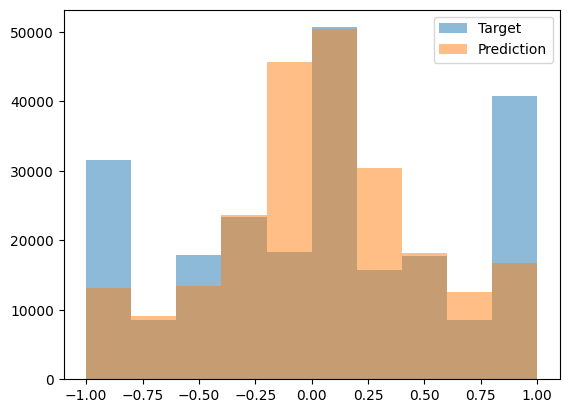

In [11]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [12]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [13]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Create feature types list for XGBoost
    feature_types = [
        "c" if col in categorical_cols else "q" 
        for col in numerical_cols + categorical_cols
    ]

    # Create XGBoost DMatrix for test data
    test_dmatrix = xgb.DMatrix(
        data=test_processed[numerical_cols + categorical_cols],
        feature_types=feature_types,
        enable_categorical=True
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_dmatrix)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [14]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

***